# Using Wikipedia, Pandas, and Folium visualize all the Ancient Libraries and Where they were

# Packages

In [24]:
import pandas as pd
import wikipedia
import geopandas as gpd
%matplotlib inline  
import folium
import os
import regex as re
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import fuzzywuzzy.process as fwp

# Variables

In [25]:
w_page = "List of libraries in the ancient world"
col_names = ["RAW_TEXT", "NAME", "EXTRA"]
output_table = "test.csv"
countries = "ne_50m_admin_0_countries.shp"

# Read in Wiki page as variable

In [26]:
w_page = wikipedia.page(w_page)
text = w_page.content

# Save as text and read back in

In [27]:
open('temp.txt', 'a').close()
with open('temp.txt', "w", encoding="utf-8") as f:
    f.write(text)

# Read text into pandas and split text up

In [28]:
df = pd.read_csv('temp.txt', sep = '==',  header = None, skiprows =1)
df.columns = col_names
df

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,RAW_TEXT,NAME,EXTRA
0,NaN,Algeria,NaN
1,Timgad (250 A.D.) (modern Algeria)The library ...,None,NaN
2,NaN,Anatolia,NaN
3,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,None,NaN
4,Royal Library of Antioch (221 B.C. - 363 A.D.)...,None,NaN
5,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,None,NaN
6,Library of Celsus (135 A.D. - 262) (located wi...,None,NaN
7,The Imperial Library of Constantinople (337â€...,None,NaN
8,NaN,China,NaN
9,Han Imperial Library. Catalogue preserved in t...,None,NaN


# Fill NAME column populating the country for each library

In [29]:
df.iloc[:, 1] = df.iloc[:, 1].fillna(method='ffill')
df2 = df[pd.notnull(df.iloc[:, 0])]
df2 = df2[~df2.NAME.str.contains('External links|See also|References')]
df2 = df2 = df2[~df2.RAW_TEXT.str.contains('Qin reign|Tang dynasty|The great seats of learning')]

# Initial Cleanup

In [30]:
##Strip extra characters and fix one country issue
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace('=','')
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace(' ','')
df2.iloc[:, 1] = df2.iloc[:, 1].str.replace('Anatolia','Turkey')

In [31]:
##Initial work to seperate text contained in paranthesis - both dates and locations
split1 = df2['RAW_TEXT'].str.split('(', n = 1, expand = True)
df2['Temp'] = split1[1]
split2 = df2['Temp'].str.split(')', n = 1, expand = True)
df2['Date'] = split2[0]
df2['Temp2'] = split2[1]
split3 = df2['Temp2'].str.split('(', n = 1, expand = True)
split4 = split3[1].str.split(')', n = 1, expand = True)
df2['Loc'] = split4[0]
df2['Extra'] = split4[1]
split1 = split1[0].str.split(',', n = 1, expand = True)
split1 = split1[0].str.split('.', n = 1, expand = True)
df2['Library'] = split1[0]
df2 = df2.drop(['Temp', 'Temp2'], axis=1)
df2

,RAW_TEXT,NAME,EXTRA,Date,Loc,Extra,Library
1,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,NaN,250 A.D.,modern Algeria,The library was a gift to the Roman people and...,Timgad
3,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,NaN,1900 B.C. - 1190 B.C.,modern Bogazkoy,This archive constituted the largest collectio...,Hattusa
4,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,NaN,221 B.C. - 363 A.D.,Modern Antakya,The library was commissioned in the third cent...,Royal Library of Antioch
5,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,NaN,197 B.C. - 159 B.C.,modern Bergama,The Attalid kings formed the second best Helle...,Library of Pergamum
6,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,NaN,135 A.D. - 262,located within the city of Ephesus,This library was part of the triumvirate of li...,Library of Celsus
7,The Imperial Library of Constantinople (337â€...,Turkey,NaN,337â€“361 A.D. â€“ 29 May 1453,"Constantinople, modern Istanbul",The library was established by Constantius II ...,The Imperial Library of Constantinople
9,Han Imperial Library. Catalogue preserved in t...,China,NaN,None,None,None,Han Imperial Library
13,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,NaN,c. 295 BC,None,None,The Royal Library of Alexandria
14,"Serapeum of Alexandria, offshoot collection of...",Egypt,NaN,None,None,None,Serapeum of Alexandria
15,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,NaN,237â€“57 B.C.,None,None,Temple of Edfu Archive/Library


# Add links to table

In [32]:
libs = list(df2['Library'])
a = []
for w in libs: 
    try:
        page = wikipedia.page(w)
        a.append(page.url)
    except:
        pass # doing nothing on exception
df_tmp = pd.DataFrame(a)
df_tmp = df_tmp.rename(columns={df_tmp.columns[0]: "Links" })
df_tmp['tmp']= df_tmp['Links'].replace('https://en.wikipedia.org/wiki/', '', regex=True)
df_tmp['tmp']= df_tmp['tmp'].replace('_', ' ', regex=True)


C:\Users\fcmun\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\fcmun\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [33]:
choices = list(df_tmp.tmp)
def fmatch(row): 
    minscore=90 #or whatever score works for you
    choice,score = fwp.extractOne(row.Library,choices)
    return choice if score > minscore else None

df2['test'] = df2.apply(fmatch, axis=1)
df3= pd.merge(df2, 
                  df_tmp,
                  left_on='test',
                  right_on='tmp',
                  how = 'left') 
df3['Links']= df3['Links'].replace(np.nan, 'None', regex=True)

# Work to put dates and locations in correct columns. 

In [34]:
#Putting all Dates that are in three different columns into one
df3['Date_F'] = np.where(df3['Date'].str.contains('A.D.|B.C.|cent|Cent'), df3['Date'], 0)
df3['Date_Temp'] = np.where(df3['Loc'].str.contains('A.D.|B.C.|cent|Cent'), df3['Loc'], 0)
df3.loc[df3["Date_F"]==0,'Date_F'] = df3['Date_Temp']
df3 = df3.drop(['Date_Temp'], axis=1)

In [35]:
#Putting locations that are in three different columns into one
df3['Loc_F'] = np.where(df3['Loc'].str.contains(r"[a-z]"), df3['Loc'], 0)
df3['Loc_F'] = np.where(~df3['Loc_F'].str.contains('cent|Cent', na = False), df3['Loc_F'], 0)
df3['Loc_Temp'] = np.where(df3['Date'].str.contains(r"[a-z]"), df3['Date'], 0)
df3['Loc_Temp'] = np.where(~df3['Loc_Temp'].str.contains(r"[0-9]|Cent|cent", na = False), df3['Loc_Temp'], 0)
df3.loc[df3["Loc_F"]==0,'Loc_F'] = df3['Loc_Temp']
df3 = df3.drop(['Loc_Temp', 'Date', 'Loc'], axis=1)

# Focus on creating start and end dates

In [36]:
##Start Date
split_date = df3['Date_F'].str.split('-|â€“|to', n = 2, expand = True)
split_date[3] = np.where(split_date[1].str.contains('B.C.|BC', na=False), " B.C.", '')
split_date[4] = np.where(~split_date[0].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[3], split_date[0])
split_date[5] = np.where(split_date[1].str.contains('A.D.', na=False), " A.D.", '')
split_date[4] = np.where(~split_date[4].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[5], split_date[4])
split_date[5] = np.where(split_date[1].str.contains('A.D.', na=False), " A.D.", '')
split_date[4] = np.where(~split_date[4].str.contains('B.C.|A.D.|Cent|Cent', na=False), split_date[0] + split_date[5], split_date[4])
##Cheat
split_date[4].replace({'8th century': '8 A.D.'},inplace =True)
split_date[4].replace({'third century BCE': '3 B.C.'},inplace =True)
split_date[4].replace({'12th Century': '12 A.D.'},inplace =True)
split_date[4].replace({'9th': '9 A.D.'},inplace =True)
##End Date
split_date[6] = np.where(split_date[0].str.contains('A.D.', na=False), " A.D.", '')
split_date[7] = np.where(~split_date[1].str.contains('B.C.|A.D.|Cent|Cent|None', na=False), split_date[1] + split_date[6], split_date[1])
##Cheat
split_date[7].replace({'10th century': '10 A.D.'},inplace =True)
split_date[7].replace({'13th centuries': '13 A.D.'},inplace =True)
split_date[7].replace({' 5th century BC in modern': '5 B.C.'},inplace =True)
split_date = split_date.drop([2, 3,5,6], axis=1)

In [37]:
##Adding dates back in and removing not needed columns
df3['Start_Date'] = split_date[4]
df3['End_Date'] = split_date[7]
df3 = df3.drop(['EXTRA', 'Date_F'], axis=1)
df3.head()


,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Loc_F,Start_Date,End_Date
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,modern Algeria,250 A.D.,NaN
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,modern Bogazkoy,1900 B.C.,1190 B.C.
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,Modern Antakya,221 B.C.,363 A.D.
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,modern Bergama,197 B.C.,159 B.C.
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,located within the city of Ephesus,135 A.D.,262 A.D.


In [38]:
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Loc_F,Start_Date,End_Date
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,modern Algeria,250 A.D.,NaN
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,modern Bogazkoy,1900 B.C.,1190 B.C.
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,Modern Antakya,221 B.C.,363 A.D.
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,modern Bergama,197 B.C.,159 B.C.
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,located within the city of Ephesus,135 A.D.,262 A.D.
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,"Constantinople, modern Istanbul",337 A.D.,361 A.D.
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,0,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,0,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,0,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,0,237 B.C.,57 B.C.


# Cleaning up location column

In [39]:
##Removing modern terms
df3['Location'] = df3['Loc_F'].str.lstrip('Modern |modern |ar modern')
##Cheats
df3['Location'].replace({'located within the city of Ephesus': 'Ephesus'},inplace =True)
df3['Location'].replace({'Constantinople, modern Istanbul': 'Istanbul'},inplace =True)
df3['Location'].replace({'sul, Iraq': 'Sul'},inplace =True)
df3['Location'].replace({'Northeast Syria': None},inplace =True)
df3['Location'].replace({'Algeria': None},inplace =True)
df3 = df3.drop(['Loc_F'], axis=1)
df3['Loc_Geo'] = df3['Location'] + ', ' + df3['NAME']
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Location,Loc_Geo
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,250 A.D.,NaN,None,NaN
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,Bogazkoy,"Bogazkoy, Turkey"
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,Antakya,"Antakya, Turkey"
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,Bergama,"Bergama, Turkey"
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,Ephesus,"Ephesus, Turkey"
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,Istanbul,"Istanbul, Turkey"
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,NaN,NaN,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,NaN,NaN,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,NaN,NaN,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,237 B.C.,57 B.C.,NaN,NaN


In [40]:
df3['Start_Date_Y']  = np.where(df3['Start_Date'].str.contains('B.C.'), df3['Start_Date'], 0)
df3['Start_Date_Y'] = df3['Start_Date_Y'].str.replace('B.C.|th','')
df3['Start_Date_Y'] = ('-' + df3['Start_Date_Y'])
df3["Start_Date_Y"] = df3["Start_Date_Y"].fillna(0)
df3.loc[df3["Start_Date_Y"]== 0 ,"Start_Date_Y"] = df3['Start_Date']
df3['Start_Date_Y'] = df3['Start_Date_Y'].str.replace('A.D.','')
df3['Start_Date']= df3['Start_Date'].replace(np.nan, 'Unknown', regex=True)
df3

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Location,Loc_Geo,Start_Date_Y
0,Timgad (250 A.D.) (modern Algeria)The library ...,Algeria,The library was a gift to the Roman people and...,Timgad,Timgad,https://en.wikipedia.org/wiki/Timgad,Timgad,250 A.D.,NaN,None,NaN,250
1,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,Bogazkoy,"Bogazkoy, Turkey",-1900
2,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,Antakya,"Antakya, Turkey",-221
3,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,Bergama,"Bergama, Turkey",-197
4,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,Ephesus,"Ephesus, Turkey",135
5,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,Istanbul,"Istanbul, Turkey",337
6,Han Imperial Library. Catalogue preserved in t...,China,None,Han Imperial Library,None,None,NaN,Unknown,NaN,NaN,NaN,NaN
7,"The Royal Library of Alexandria, Egypt, fl. 3r...",Egypt,None,The Royal Library of Alexandria,Library of Alexandria,https://en.wikipedia.org/wiki/Library_of_Alexa...,Library of Alexandria,Unknown,NaN,NaN,NaN,NaN
8,"Serapeum of Alexandria, offshoot collection of...",Egypt,None,Serapeum of Alexandria,Serapeum of Alexandria,https://en.wikipedia.org/wiki/Serapeum_of_Alex...,Serapeum of Alexandria,Unknown,NaN,NaN,NaN,NaN
9,Temple of Edfu Archive/Library (237â€“57 B.C.)...,Egypt,None,Temple of Edfu Archive/Library,None,None,NaN,237 B.C.,57 B.C.,NaN,NaN,-237


# Pulling coodrinates for locations

In [41]:
##Drop nulls
libs_cityloc =  df3.loc[df3.Loc_Geo.notnull()]
##Using geopy to extract coordinates from place name and location back to dataframe
geolocator = Nominatim()
libs_cityloc_ = libs_cityloc.filter(['Loc_Geo'], axis=1)
libs_cityloc_
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
libs_cityloc_['location'] = libs_cityloc_['Loc_Geo'].apply(geocode)
libs_cityloc_['point'] = libs_cityloc_['location'].apply(lambda loc: tuple(loc.point) if loc else None)
libs_cityloc = pd.merge(libs_cityloc, libs_cityloc_, how='left', on= 'Loc_Geo')

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.
RateLimiter caught an error, retrying (0/2 tries). Called with (*('Kos, Greece',), **{}).
Traceback (most recent call last):
  File "C:\Users\fcmun\Anaconda3\lib\urllib\request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\fcmun\Anaconda3\lib\http\client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\U

In [43]:
#Locations are stored as tuples, split it up and create lat/lon column
libs_cityloc =  libs_cityloc.loc[libs_cityloc.point.notnull()]
tmp = pd.DataFrame(libs_cityloc['point'].tolist(), index=libs_cityloc.index)   
libs_cityloc['Lat']=tmp[0]
libs_cityloc['Lon']=tmp[1]
libs_cityloc['Info'] = libs_cityloc['Library'] + ', Creation Date: ' + libs_cityloc['Start_Date'] + ', Wiki link: ' + libs_cityloc['Links']
##libs_cityloc['Info']= libs_cityloc['Info'].replace(np.nan, 'No Info', regex=True)
libs_cityloc

C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\fcmun\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,RAW_TEXT,NAME,Extra,Library,test,Links,tmp,Start_Date,End_Date,Location,Loc_Geo,Start_Date_Y,location,point,Lat,Lon,Info
0,Hattusa (1900 B.C. - 1190 B.C.) (modern Bogazk...,Turkey,This archive constituted the largest collectio...,Hattusa,Hattusa,https://en.wikipedia.org/wiki/Hattusa,Hattusa,1900 B.C.,1190 B.C.,Bogazkoy,"Bogazkoy, Turkey",-1900,"(Boğazköy, Nevşehir merkez, Nevşehir, İç Anado...","(38.5472734, 34.6360644, 0.0)",38.547273,34.636064,"Hattusa , Creation Date: 1900 B.C. , Wiki link..."
1,Royal Library of Antioch (221 B.C. - 363 A.D.)...,Turkey,The library was commissioned in the third cent...,Royal Library of Antioch,Library of Antioch,https://en.wikipedia.org/wiki/Library_of_Antioch,Library of Antioch,221 B.C.,363 A.D.,Antakya,"Antakya, Turkey",-221,"(Antakya, Antakya (merkez), Hatay, Akdeniz Böl...","(36.2176872, 36.1653617, 0.0)",36.217687,36.165362,"Royal Library of Antioch , Creation Date: 221 ..."
2,Library of Pergamum (197 B.C. - 159 B.C.) (mod...,Turkey,The Attalid kings formed the second best Helle...,Library of Pergamum,Library of Pergamum,https://en.wikipedia.org/wiki/Library_of_Pergamum,Library of Pergamum,197 B.C.,159 B.C.,Bergama,"Bergama, Turkey",-197,"(Bergama, İzmir, Ege Bölgesi, 35700, Türkiye, ...","(39.1191544, 27.1777296, 0.0)",39.119154,27.177730,"Library of Pergamum , Creation Date: 197 B.C. ..."
3,Library of Celsus (135 A.D. - 262) (located wi...,Turkey,This library was part of the triumvirate of li...,Library of Celsus,Library of Celsus,https://en.wikipedia.org/wiki/Library_of_Celsus,Library of Celsus,135 A.D.,262 A.D.,Ephesus,"Ephesus, Turkey",135,"(Efes, Arkadiane, Selçuk, İzmir, Ege Bölgesi, ...","(37.94044555, 27.3393194464968, 0.0)",37.940446,27.339319,"Library of Celsus , Creation Date: 135 A.D. , ..."
4,The Imperial Library of Constantinople (337â€...,Turkey,The library was established by Constantius II ...,The Imperial Library of Constantinople,Imperial Library of Constantinople,https://en.wikipedia.org/wiki/Imperial_Library...,Imperial Library of Constantinople,337 A.D.,361 A.D.,Istanbul,"Istanbul, Turkey",337,"(İstanbul, Fatih, İstanbul, Marmara Bölgesi, 3...","(41.0096334, 28.9651646, 0.0)",41.009633,28.965165,"The Imperial Library of Constantinople , Crea..."
5,The Library of Aristotle (Athens) (384â€“321 B...,Greece,The Library of Aristotle was a private library...,The Library of Aristotle,None,None,NaN,384 B.C.,321 B.C.,Athens,"Athens, Greece",-384,"(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Aristotle , Creation Date: 384 ..."
6,The Library of Aristotle (Athens) (384â€“321 B...,Greece,The Library of Aristotle was a private library...,The Library of Aristotle,None,None,NaN,384 B.C.,321 B.C.,Athens,"Athens, Greece",-384,"(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Aristotle , Creation Date: 384 ..."
7,Kos Library (Kos) (100 A.D.)The library was a ...,Greece,The library was a local public library situate...,Kos Library,None,None,NaN,100 A.D.,NaN,Kos,"Kos, Greece",100,"(Δήμος Κω, Περιφερειακή Ενότητα Κω, Περιφέρεια...","(36.7939719, 27.0850810793972, 0.0)",36.793972,27.085081,"Kos Library , Creation Date: 100 A.D., Wiki li..."
8,The Library of Pantainos (Athens) (100 A.D.)De...,Greece,Dedicated to both Athena Archegetis and the Ro...,The Library of Pantainos,None,None,NaN,100 A.D.,NaN,Athens,"Athens, Greece",100,"(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Pantainos , Creation Date: 100 ..."
9,The Library of Pantainos (Athens) (100 A.D.)De...,Greece,Dedicated to both Athena Archegetis and the Ro...,The Library of Pantainos,None,None,NaN,100 A.D.,NaN,Athens,"Athens, Greece",100,"(Αθήνα, Δήμος Αθηναίων, Π.Ε. Κεντρικού Τομέα Α...","(37.9841493, 23.7279843, 0.0)",37.984149,23.727984,"The Library of Pantainos , Creation Date: 100 ..."


# Creating map that shows where Ancient Libraries were located (City Level)

In [46]:
mkr = folium.Map(location=[35.283731, 35.203442], tiles='stamenterrain', zoom_start=5)
libs_cityloc.apply(lambda row:folium.Marker(location=[row["Lat"], row["Lon"]], popup=row['Info'],).add_to(mkr),axis=1)
mkr.save(outfile= "Library_Locations.html")
mkr

# Create Chloropleth using Folium package. Save off as HTML file.  

In [ ]:
#Group data
groups = df2.groupby('NAME', as_index=False).count()
groups1 = groups.drop(['RAW_TEXT'], axis=1)

In [ ]:
#Read in country shapefile and merge with groups to only keep countries that have ancient libraries.  Save the that geodataframe off as json file
geo_data = gpd.read_file(countries, encoding="utf-8")
country_shapes = geo_data.merge(groups, on='NAME', how='right')
geo_data.plot()
country_shapes.plot('NAME', cmap='OrRd', legend = True)
country_shapes = country_shapes[['NAME', 'geometry']]
country_shapes = country_shapes[pd.notnull(country_shapes['geometry'])]
country_shapes
country_shapes.to_file('country2.json', driver='GeoJSON')

In [ ]:
##create cholorepleth showing counts of ancient libraries in each country
country_geo = os.path.join('country2.json')
m = folium.Map(location=[30.3755321, 69.345116], tiles='stamentoner', zoom_start=3)
m.choropleth(
 geo_data=country_geo,
 name='choropleth',
 data=groups,
 columns=['NAME', 'Library'],
 key_on='feature.properties.NAME',
 fill_color='BuGn',
 fill_opacity=0.7,
 line_opacity=0.0,
 legend_name='Libraries'
)
folium.LayerControl().add_to(m)
m.save(outfile= "Countries_LibraryCNT.html")
##os.remove("country2.json")
##os.remove("temp.txt")
m

In [86]:
date_compare = df3.filter(['Library', 'Start_Date', 'Start_Date_Y'], axis=1)
date_compare['current_date'] = 2018
date_compare = date_compare.dropna(subset=['Start_Date_Y'])
date_compare['Start_Date_Y'] = pd.to_numeric(date_compare['Start_Date_Y'], errors='coerce')
date_compare['current_date'] = pd.to_numeric(date_compare['current_date'], errors='coerce')
date_compare['Years'] = np.where(date_compare['Start_Date'].str.contains('A.D.', na=False), date_compare['current_date'] - date_compare['Start_Date_Y'], '')
date_compare.loc[date_compare["Start_Date"].str.contains('B.C.',), 'Years'] = date_compare['current_date'] - date_compare['Start_Date_Y'] -1
date_compare

,Library,Start_Date,Start_Date_Y,current_date,Years
0,Timgad,250 A.D.,250,2018,1768
1,Hattusa,1900 B.C.,-1900,2018,3917
2,Royal Library of Antioch,221 B.C.,-221,2018,2238
3,Library of Pergamum,197 B.C.,-197,2018,2214
4,Library of Celsus,135 A.D.,135,2018,1883
5,The Imperial Library of Constantinople,337 A.D.,337,2018,1681
9,Temple of Edfu Archive/Library,237 B.C.,-237,2018,2254
11,The Library of Aristotle,384 B.C.,-384,2018,2401
12,Kos Library,100 A.D.,100,2018,1918
13,The Library of Pantainos,100 A.D.,100,2018,1918


Text(0,0.5,'Number of Years')

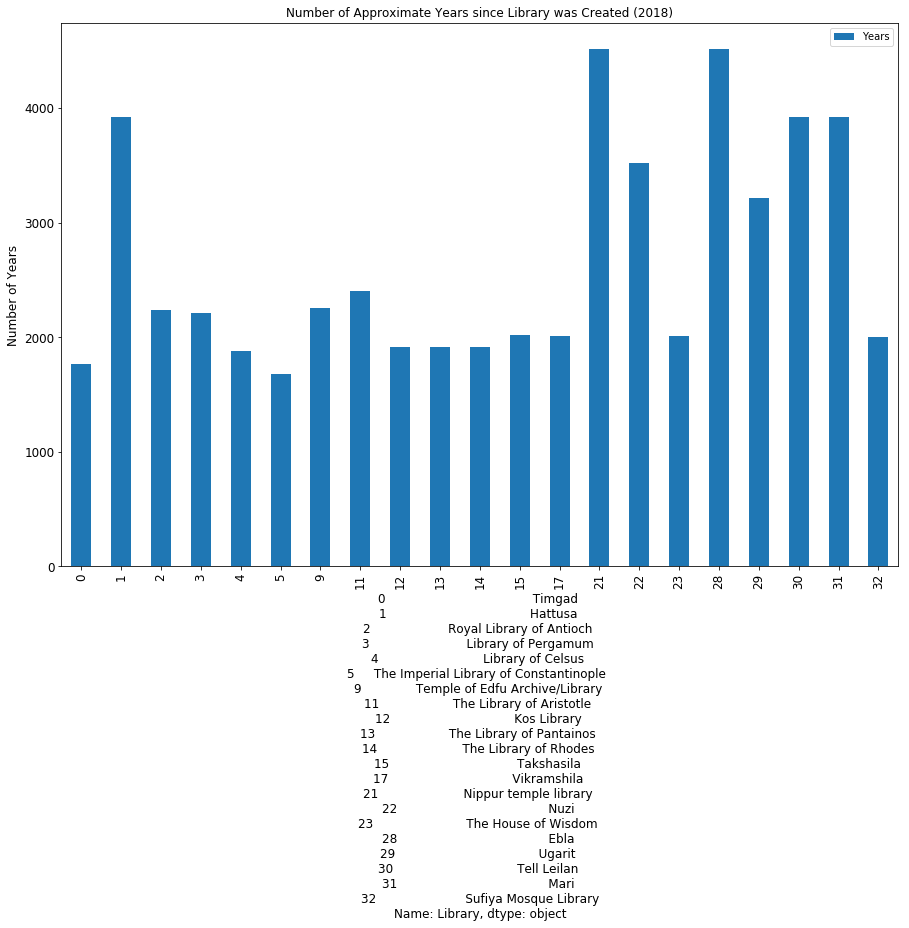

In [99]:
import matplotlib.pyplot as plt
date_compare['Years'] = pd.to_numeric(date_compare['Years'], errors='coerce')
date_compare2 = date_compare.filter(['Library', 'Years'], axis=1)
##date_compare2.plot.bar(figsize=(15,8))


ax = date_compare2.plot(kind='bar', title ="Number of Approximate Years since Library was Created (2018)",figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel(date_compare['Library'],fontsize=12)
ax.set_ylabel("Number of Years",fontsize=12)

# Extra Stuff

In [ ]:
##geo_data.to_file('country.geojson', driver='GeoJSON')
##country_geo = os.path.join('country.geojson')
##https://deparkes.co.uk/2016/06/10/folium-map-tiles/
##https://stackoverflow.com/questions/53571106/choropleth-with-folium
##https://stackoverflow.com/questions/16842001/copy-text-between-parentheses-in-pandas-dataframe-column-into-another-column
##https://stackoverflow.com/questions/22588316/pandas-applying-regex-to-replace-values
##https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html
##https://stackoverflow.com/questions/15857797/bc-dates-in-python
##https://stackoverflow.com/questions/43089275/numpy-where-with-like-operator
##https://stackoverflow.com/questions/47723919/iterate-geolocation-over-pandas-dataframe
##https://automating-gis-processes.github.io/CSC18/lessons/L3/geocoding.html
##https://geopy.readthedocs.io/en/stable/#usage-with-pandas
##https://stackoverflow.com/questions/42756934/how-to-plot-lat-and-long-from-pandas-dataframe-on-folium-map-group-by-some-label
##https://stackoverflow.com/questions/35380933/how-to-merge-two-pandas-dataframes-based-on-a-similarity-function

In [ ]:
##libs_cityloc['nameurl'] = libs_cityloc['Library'] + '#' + libs_cityloc['Key']
##def make_clickable_both(val): 
    ##name, url = val.split('#')
    ##return f'<a href="{url}">{name}</a>'

##libs_cityloc.reset_index().style.format({'nameurl': make_clickable_both})